In [2]:
import os
import glob

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from debugpy.launcher import channel

from utils.util import preprocessing, order_points
from dotenv import load_dotenv

"""
LOAD CONFIGURATIONS FROM .env FILE
"""
load_dotenv()

TRAIN_DATASET_CONNECT_PATH = f'{os.getcwd()}/{os.getenv("TRAIN_DATASET_CONNECT_PATH")}'

## Qwirkle Connect
*This Jupyter Notebook presents the work done by Vrinceanu Radu-Tudor (group 407 - Artificial Intelligence) for the Computer Vision subject.*

First step that I want to do is to import configs from the ```load_dotenv``` option that populates inside the Jupyter's Notebook runtime environment variables. After that we want to take each game image (load aprox. 21 images in memory 20 - which represents the whole game + 1 starting image). The starting image will represent the point for the "wrapping" algorithm that can center the board and remove translations or rotations. I also want to do for the first image (i.e. the starting one) the extraction of the board from the background by converting the image into an HSV color space and use some thresholds to obtain a mask that can be used in the retrieval of the board itself.

### First chapter of the adventure
**Extract just the boardgame from the starting image from the mask**

I know that each image of type ```g_00.jpg``` where $g = [1, 5]$ and g is a natural number. I define the function ```extract_boardgame_from_starting_image``` I will take the low and high threshold of hsv values to remove the surface on which the boardgame is placed. After that the Canny function will be used to fetch the edges and also determine the biggest polygon that can be build using the contour with the maximum area. This works because after applying the ```bitwise_and``` with the mask the remaining image will have a black background (i.e. dead pixels).

In [30]:
def extract_boardgame_from_image(image_name, path_to_dataset=TRAIN_DATASET_CONNECT_PATH):    
    first_image_path = os.path.join(path_to_dataset, f"{image_name}.jpg")
    first_image = cv.imread(first_image_path, cv.IMREAD_COLOR_BGR|cv.IMREAD_IGNORE_ORIENTATION)
    first_image = cv.resize(first_image, None, fx=0.8, fy=0.8)
    
    first_image_preprocessing = preprocessing(first_image) # get rid of textures by using median blur filters (texture can bring up noise in corner detection)
    
    hsv_threshold_low, hsv_threshold_high = (15, 0, 0), (255, 255, 255)
    hsv_first_image_preprocessing = cv.cvtColor(first_image_preprocessing, cv.COLOR_BGR2HSV)
    board_mask = cv.inRange(hsv_first_image_preprocessing, hsv_threshold_low, hsv_threshold_high)
    
    first_board_image = cv.bitwise_and(first_image, first_image, mask=board_mask)
    
    median_pixel_value = np.median(first_board_image)
    lower_threshold = int(max(0, (1.0 - 0.33) * median_pixel_value))
    upper_threshold = int(min(255, (1.0 + 0.33) * median_pixel_value))
    
    edges = cv.Canny(first_board_image, lower_threshold, upper_threshold)
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv.dilate(edges, kernel, iterations=1) # because of the noise on the edges these should be dilated to extract them!
    
    # plt.figure(figsize=[40, 10])
    # plt.axis('off'); plt.imshow(dilated_edges); plt.title('Canny Edges')
    
    contours, _ = cv.findContours(dilated_edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # cv.drawContours(first_board_image, contours, -1, (255, 0, 0), 1)
    # plt.figure(figsize=[40, 10])
    # plt.axis('off'); plt.imshow(first_board_image); plt.title('Contour boardgame')
    
    maximum_contour_area, best_contour_idx = 0.0, 0
    for (idx, contour) in enumerate(contours):
        area = cv.contourArea(contour)
        if area > maximum_contour_area:
            best_contour_idx = idx
            maximum_contour_area = area

    contour = contours[best_contour_idx]
    perimeter = cv.arcLength(contour, True)
    corners = cv.approxPolyDP(contour, 0.02 * perimeter, True)
    corners = order_points(corners) # @TODO refactor this code from this
    # corners[0][0] -= 10; corners[0][1] -= 10
    # corners[3][0] += 10; corners[3][1] += 10
    # if corners[1][0] > corners[1][1]:
    #     corners[1][0] -= 10; corners[1][1] -= 10
    #     corners[2][0] += 10; corners[2][1] += 10
    # else:
    #     corners[2][0] -= 5; corners[2][1] -= 5
    #     corners[1][0] += 5; corners[1][1] += 5
        
    cv.drawContours(first_board_image, [corners], -1, (0, 255, 0), 20)
    plt.figure(figsize=[40, 10])
    plt.axis('off'); plt.imshow(first_board_image); plt.title('Contour boardgame')
    
    margin = 16
    height_with_gap, width_with_gap = 960 + margin*2, 960 + margin*2
    warp_to_with_gap = np.array([
        [margin, margin],
        [width_with_gap - margin, margin],
        [margin, height_with_gap - margin],
        [width_with_gap - margin, height_with_gap - margin]
    ]).astype(np.float32)
    perspective_matrix_with_gap = cv.getPerspectiveTransform(corners.astype(np.float32), warp_to_with_gap)

    height, width = 960, 960
    warp_to = np.array([[0, 0], [width, 0], [0, height], [width, height]]).astype(np.float32)
    perspective_matrix = cv.getPerspectiveTransform(corners.astype(np.float32), warp_to)
            
    return (cv.warpPerspective(first_image, perspective_matrix, dsize=(width, height)),
            cv.warpPerspective(first_image, perspective_matrix_with_gap, dsize=(width_with_gap, height_with_gap)))

(992, 992, 3)


Text(0.5, 1.0, 'Warpped with gap boardgame')

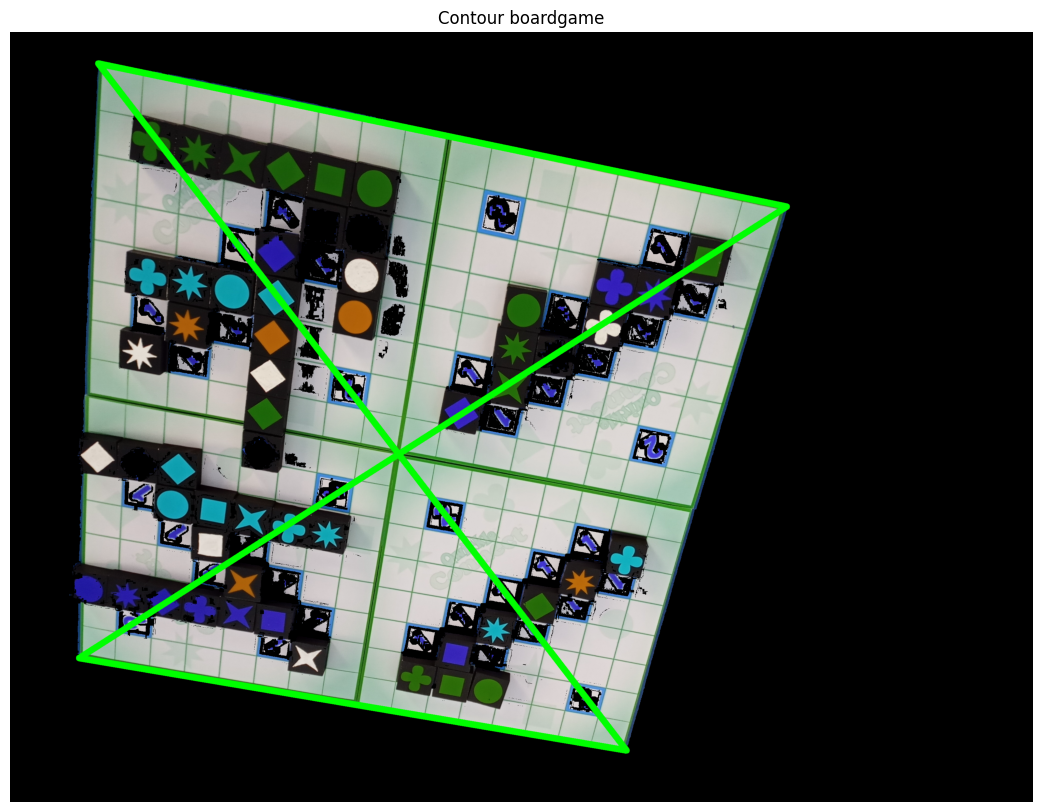

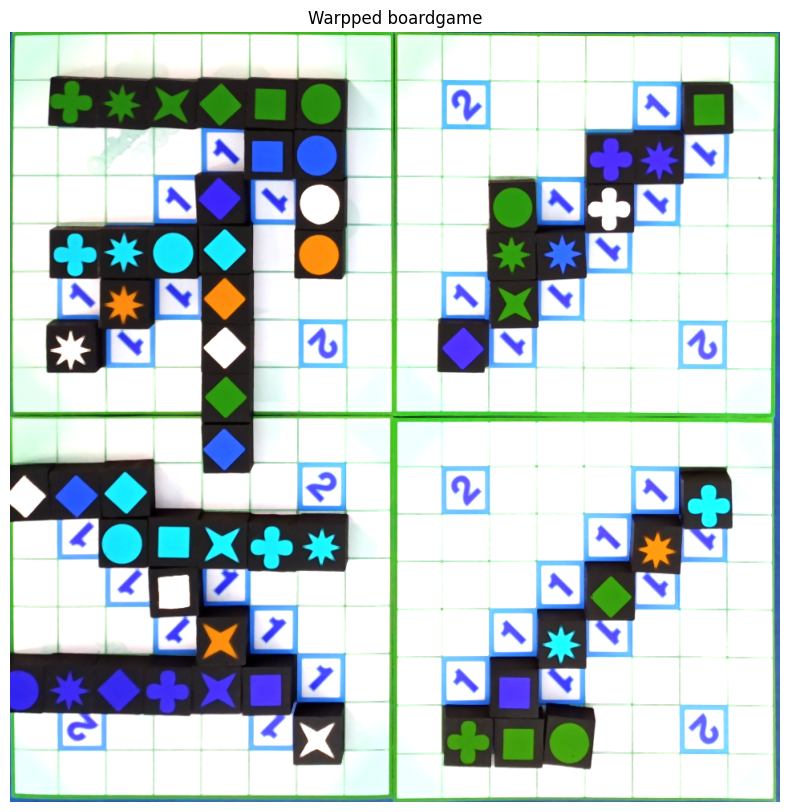

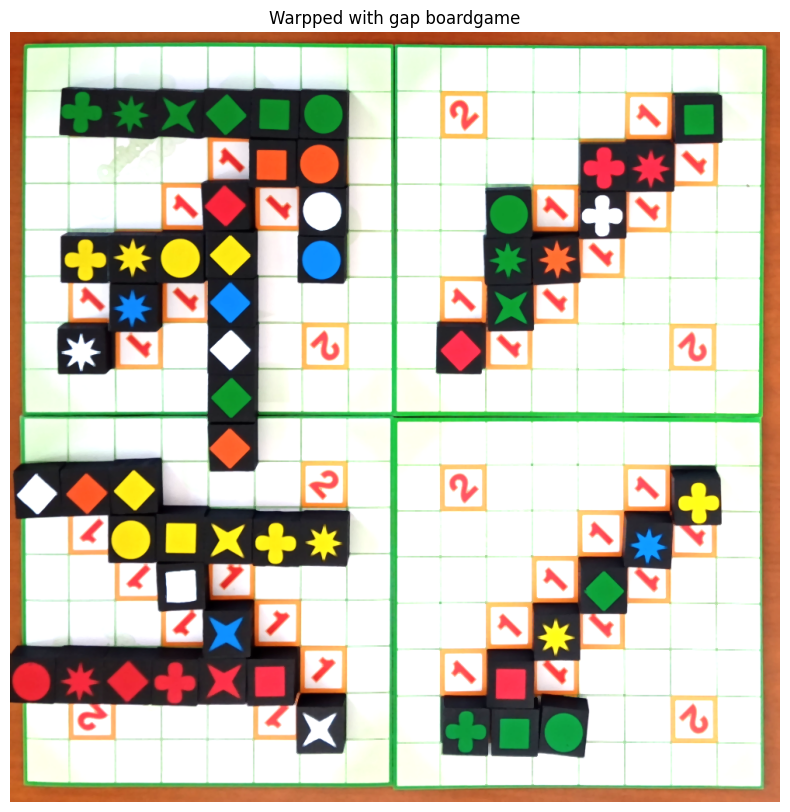

In [60]:
warp, warp_with_gap = extract_boardgame_from_image("5_14")
warp = cv.medianBlur(warp, 3)
warp = cv.morphologyEx(warp, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
warp = cv.normalize(warp, None, alpha=0, beta=350, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)

warp_with_gap = cv.medianBlur(warp_with_gap, 3)
warp_with_gap = cv.morphologyEx(warp_with_gap, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
warp_with_gap = cv.normalize(warp_with_gap, None, alpha=0, beta=350, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
print(warp_with_gap.shape)

plt.figure(figsize=[40, 10])
plt.axis('off'); plt.imshow(warp); plt.title('Warpped boardgame')

plt.figure(figsize=[40, 10])
plt.axis('off'); plt.imshow(cv.cvtColor(warp_with_gap, cv.COLOR_BGR2RGB)); plt.title('Warpped with gap boardgame')

# warp = extract_boardgame_from_image("tiles_1", "./datasets/board+tiles")
#
# plt.figure(figsize=[40, 10])
# plt.axis('off'); plt.imshow(cv.cvtColor(warp, cv.COLOR_BGR2RGB)); plt.title('Warpped boardgame')

### Second chapter of the adventure
**Extract the boardgame information (bonus points) and create a boardgame state**

Using template matching we can extract where the points sit on the table from the first image. It is guaranteed that the first image isn't that skewed and if it's the case consider the "middest" points on the table to get the orientation for each rectangle. Ensemble the game matrix based on $8x8$ patches that resembles each square of playable surface.

In [5]:
def extract_points_boardgame_from_image(image):
    game_points = np.zeros((16, 16))

    height, width = image.shape[:2]
    patch_height, patch_width = height // 16, width // 16

    list_of_points = np.array([(0, 0), (0, 1), (1, 0), (1, 1)])
    game_matrix = np.array([[
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 2, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 2, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]
    ], [
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 2, 0],
        [0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0],
        [0, 2, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]
    ]])
    list_of_roi_points = np.array([[(6, 6), (1, 6)], [(1, 9), (6, 9)], [(14, 6), (9, 6)], [(9, 9), (14, 9)]])
    template_paths = glob.glob('./datasets/templates/2_*.png')
    print(template_paths)
    templates = list(map(
        lambda template_path: cv.imread(template_path, cv.IMREAD_COLOR_BGR|cv.IMREAD_IGNORE_ORIENTATION), template_paths
    ))

    for idx, roi_points_per_square in enumerate(list_of_roi_points):
        h1, w1 = roi_points_per_square[0]
        h2, w2 = roi_points_per_square[1]

        first_patch = image[h1*patch_height+5:(h1+1)*patch_height+5, w1*patch_width+5:(w1+1)*patch_width+5]
        second_patch = image[h2*patch_height+5:(h2+1)*patch_height+5, w2*patch_width+5:(w2+1)*patch_width+5]

        plt.figure(figsize=[20, 10])
        plt.subplot(121); plt.axis('off'); plt.imshow(cv.cvtColor(first_patch, cv.COLOR_BGR2RGB)); plt.title('First Patch')
        plt.subplot(122); plt.axis('off'); plt.imshow(cv.cvtColor(second_patch, cv.COLOR_BGR2RGB)); plt.title('Second Patch')

        first_values, second_values = -np.inf, -np.inf
        for template in templates:
            first_result = cv.matchTemplate(first_patch, template, cv.TM_CCOEFF_NORMED)
            first_min_val, first_max_val, _, _ = cv.minMaxLoc(first_result)

            if h1 == 9 and w1 == 9:
                print("First Value: ", first_min_val, first_max_val)

            if first_max_val > first_values:
                first_values = first_max_val

            second_result = cv.matchTemplate(second_patch, template, cv.TM_CCOEFF_NORMED)
            second_min_val, second_max_val, _, _ = cv.minMaxLoc(second_result)

            if h1 == 9 and w1 == 9:
                print("Second Value: ", second_min_val, second_max_val)

            if second_max_val > second_values:
                second_values = second_max_val

        chosen_index = 0 if first_values > second_values else 1

        x, y = list_of_points[idx]
        game_points[x*8:(x+1)*8, y*8:(y+1)*8] = game_matrix[chosen_index]

    return game_points

['./datasets/templates/2_2.png', './datasets/templates/2_3.png', './datasets/templates/2_1.png', './datasets/templates/2_4.png']
First Value:  0.011850327253341675 0.07288156449794769
Second Value:  -0.27098172903060913 0.2093539834022522
First Value:  -0.01156225148588419 0.08280505985021591
Second Value:  -0.3377354145050049 0.18593446910381317
First Value:  0.025958681479096413 0.08239828795194626
Second Value:  -0.2533293664455414 0.20380063354969025
First Value:  0.02983800508081913 0.10042838752269745
Second Value:  -0.28706222772598267 0.27167612314224243
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 

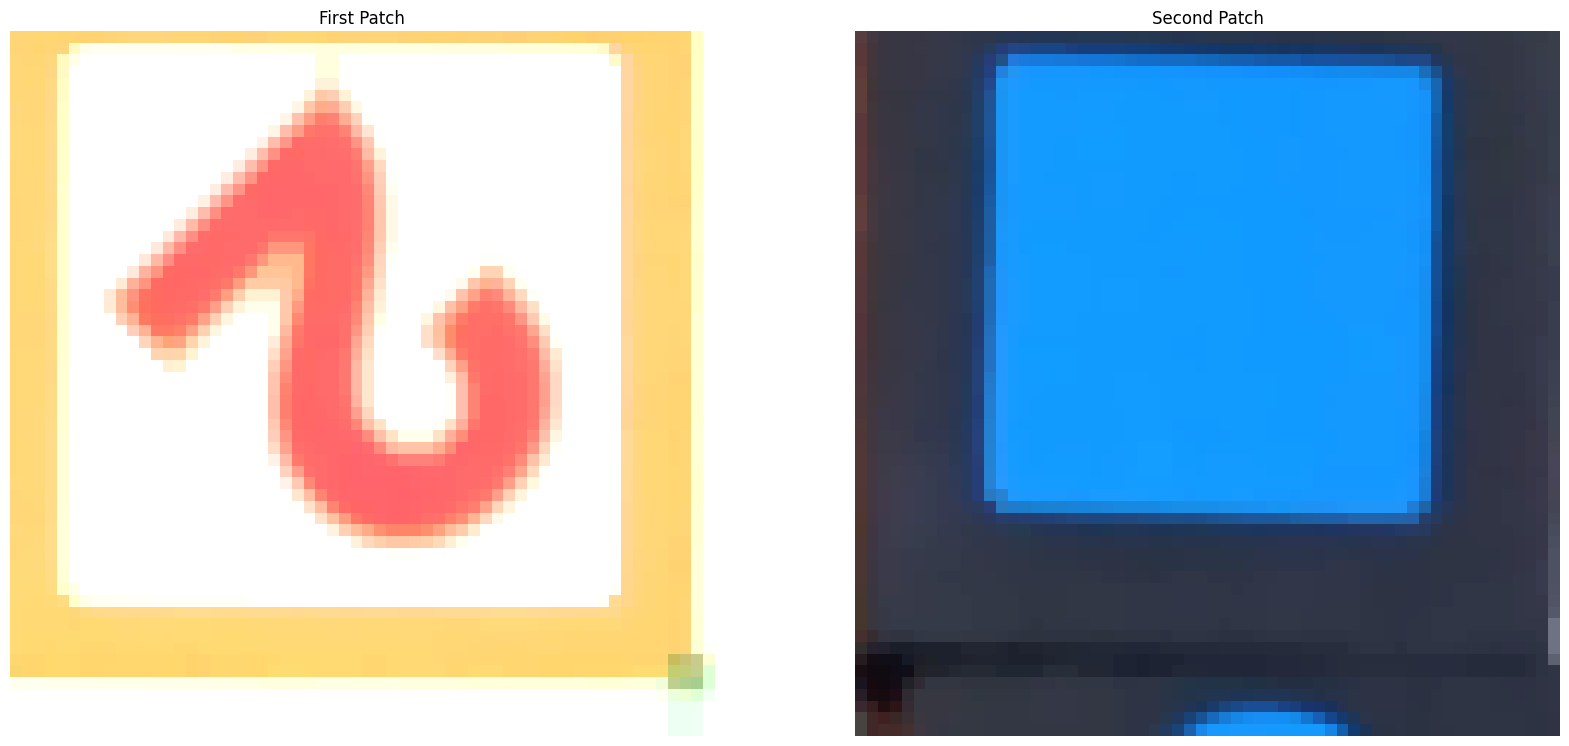

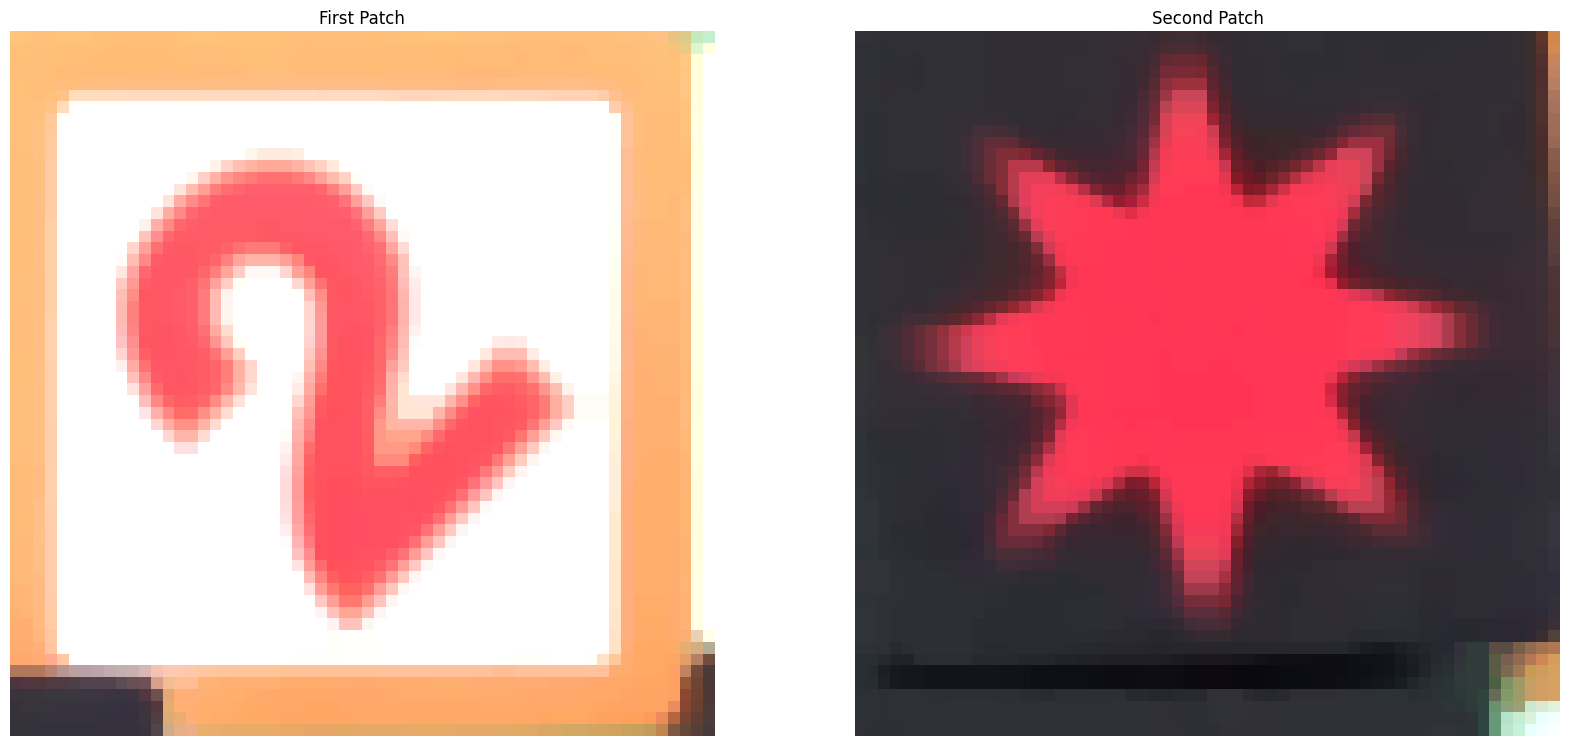

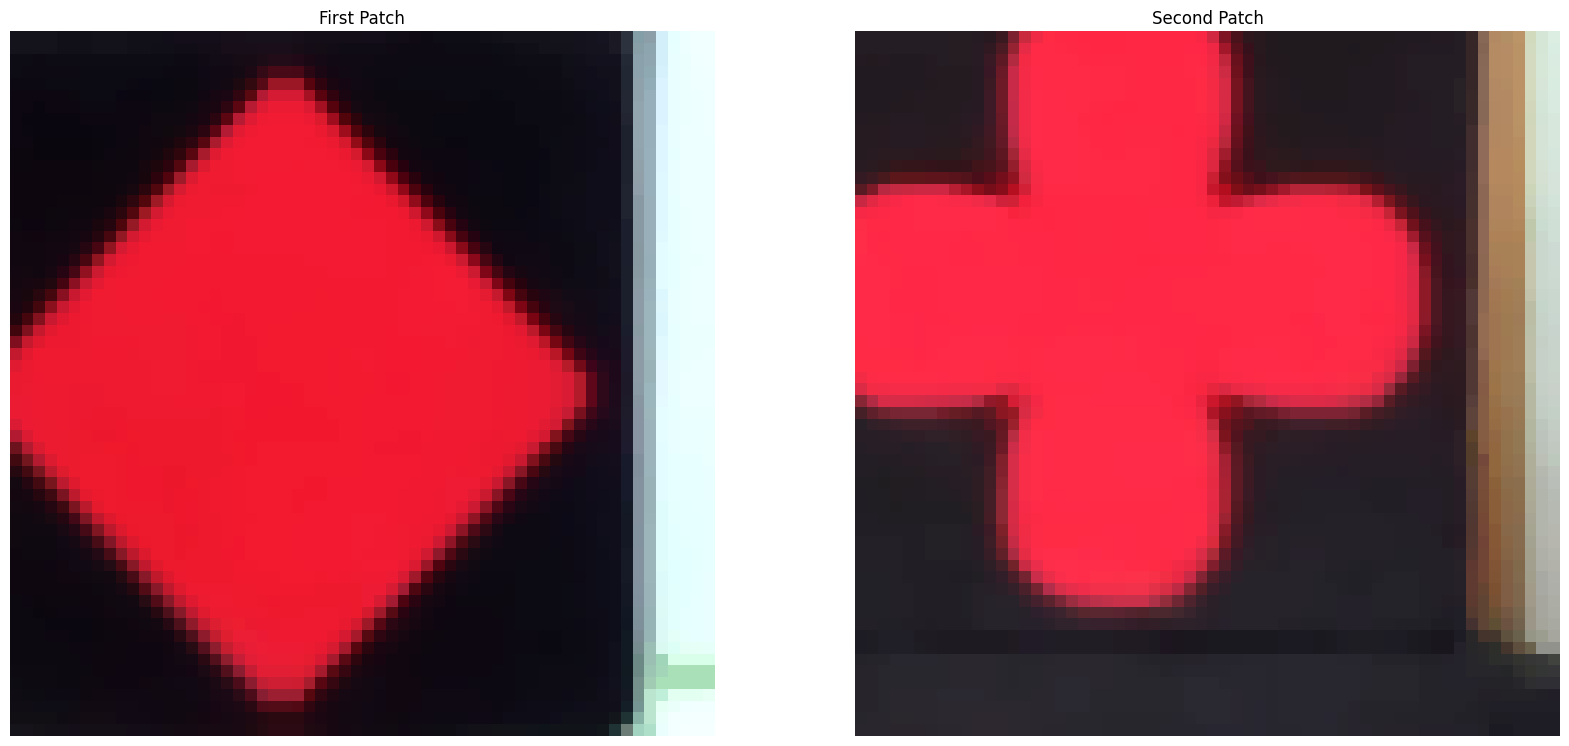

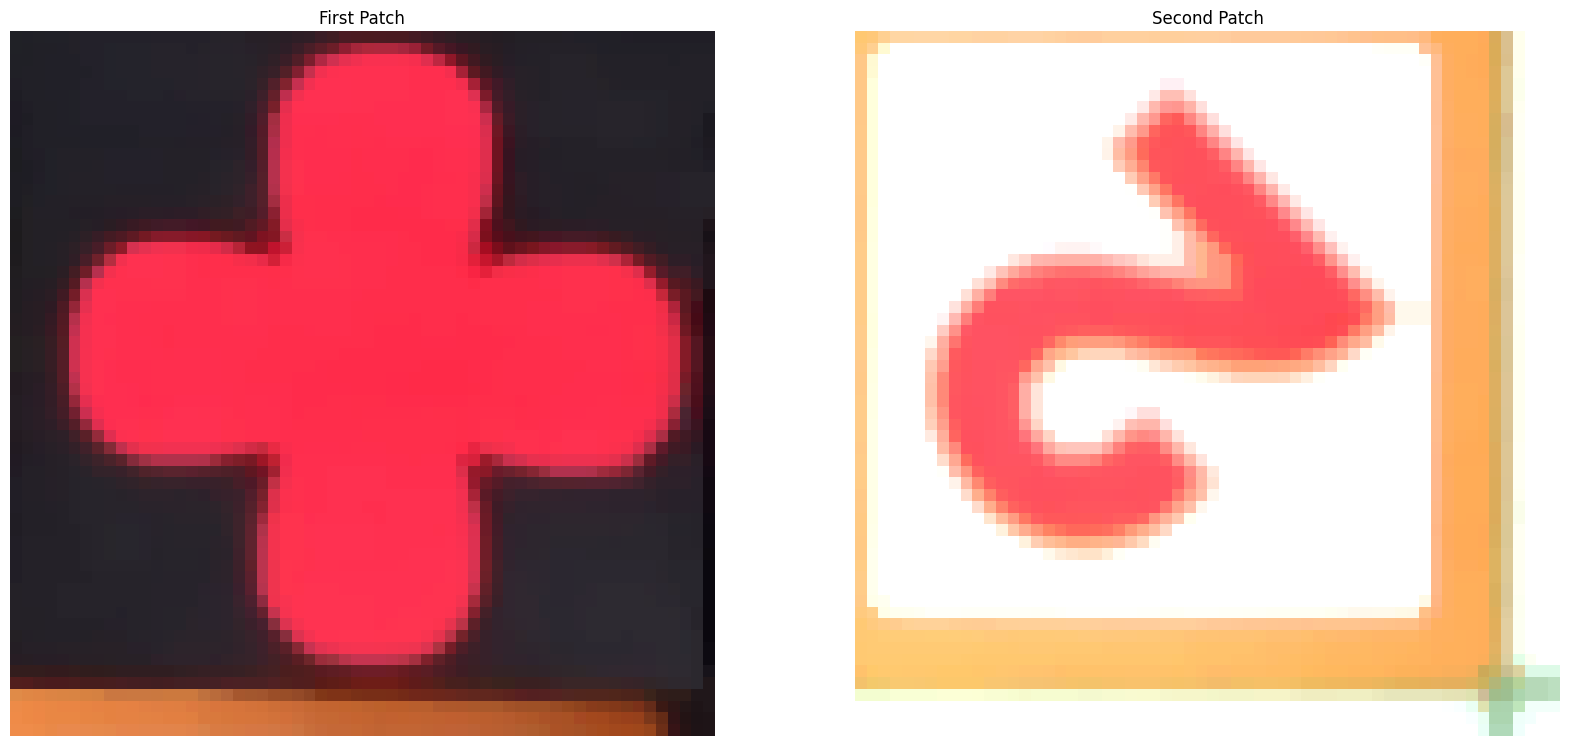

In [6]:
game_table_points = extract_points_boardgame_from_image(warp)
print(game_table_points)

### Third chapter of the adventure
**Game phase, wrap the game image to the ```g_00.jpg```**

For this we will use a variant of SIFT descriptors which are called ORB descriptors (which represents a faster variant to SIFT descriptors and a newer algorithm). The resource that helped me understand those feature can be found here: https://www.youtube.com/watch?v=_o6fSMCmNnQ. Also, this means that in the middle of the game image T warps T+1 so ```g_00.jpg``` warps ```g_01.jpg``` and so on. I also recommend this article from medium: https://mikhail-kennerley.medium.com/a-comparison-of-sift-surf-and-orb-on-opencv-59119b9ec3d0.


In [7]:
def warp_image_to_starting_image_ORB(image_name, starting_game_image, path_to_dataset=TRAIN_DATASET_CONNECT_PATH):
    game_image = extract_boardgame_from_image(image_name, path_to_dataset=TRAIN_DATASET_CONNECT_PATH)
    
    gray_starting_game_image = cv.cvtColor(starting_game_image, cv.COLOR_BGR2GRAY)
    gray_game_image = cv.cvtColor(game_image, cv.COLOR_BGR2GRAY)

    MAX_NUM_OBSERVATIONS = 500
    orb = cv.ORB_create(MAX_NUM_OBSERVATIONS)
    keypoints_starting_game_image, description_starting_game_image = orb.detectAndCompute(gray_starting_game_image, None)
    keypoints_game_image, description_game_image = orb.detectAndCompute(gray_game_image, None)

    starting_game_display_image = cv.drawKeypoints(starting_game_image, keypoints_starting_game_image, outImage=np.array([]), color=(255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    game_display_image = cv.drawKeypoints(game_image, keypoints_game_image, outImage=np.array([]), color=(255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=[20, 10])
    plt.subplot(121); plt.axis('off'); plt.imshow(starting_game_display_image); plt.title('Starting image')
    plt.subplot(122); plt.axis('off'); plt.imshow(game_display_image); plt.title('Game image')

    """
    Compute the matches and extract them and discard p% of bad matches
    """
    matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(description_starting_game_image, description_game_image, None)
    matches = sorted(matches, key=lambda x: x.distance)

    matches = matches[:int(len(matches) * 0.15)]

    display_matches_image = cv.drawMatches(starting_game_image, keypoints_starting_game_image, game_image, keypoints_game_image, matches, None)
    plt.figure(figsize=[40, 10])
    plt.axis('off'); plt.imshow(display_matches_image); plt.title('Matches')

    """
    Compute homography matrix
    """
    points_starting_game_image = np.zeros((len(matches), 2), dtype=np.float32)
    points_game_image = np.zeros((len(matches), 2), dtype=np.float32)

    for (i, match) in enumerate(matches):
        points_starting_game_image[i, :] = keypoints_starting_game_image[match.queryIdx].pt
        points_game_image[i, :] = keypoints_game_image[match.trainIdx].pt

    h, _ = cv.findHomography(points_game_image, points_starting_game_image, cv.RANSAC)

    height, width, _ = starting_game_image.shape
    warped_image = cv.warpPerspective(game_image, h, (width, height))

    plt.figure(figsize=[20, 10])
    plt.subplot(121); plt.axis('off'); plt.imshow(starting_game_image); plt.title('Starting image')
    plt.subplot(122); plt.axis('off'); plt.imshow(warped_image); plt.title('Game image - Warped')

    return warped_image
    

In [8]:
def warp_image_to_starting_image_SIFT(image_name, starting_game_image, path_to_dataset=TRAIN_DATASET_CONNECT_PATH):
    game_image = extract_boardgame_from_image(image_name, path_to_dataset=TRAIN_DATASET_CONNECT_PATH)

    sift = cv.SIFT_create()
    keypoints_starting_game_image, description_starting_game_image = sift.detectAndCompute(starting_game_image, None)
    keypoints_game_image, description_game_image = sift.detectAndCompute(game_image, None)

    # starting_game_display_image = cv.drawKeypoints(starting_game_image, keypoints_starting_game_image, outImage=np.array([]), color=(255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # game_display_image = cv.drawKeypoints(game_image, keypoints_game_image, outImage=np.array([]), color=(255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # 
    # plt.figure(figsize=[20, 10])
    # plt.subplot(121); plt.axis('off'); plt.imshow(cv.cvtColor(starting_game_display_image, cv.COLOR_BGR2RGB)); plt.title('Starting image')
    # plt.subplot(122); plt.axis('off'); plt.imshow(cv.cvtColor(game_display_image, cv.COLOR_BGR2RGB)); plt.title('Game image')

    """
    Compute the matches and extract them and discard p% of bad matches
    """
    matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_L1)
    matches = matcher.match(description_starting_game_image, description_game_image, None)
    matches = sorted(matches, key=lambda x: x.distance)

    # display_matches_image = cv.drawMatches(starting_game_image, keypoints_starting_game_image, game_image, keypoints_game_image, matches, None)
    # plt.figure(figsize=[40, 10])
    # plt.axis('off'); plt.imshow(cv.cvtColor(display_matches_image, cv.COLOR_BGR2RGB)); plt.title('Matches')

    """
    Compute homography matrix
    """
    points_starting_game_image = np.zeros((len(matches), 2), dtype=np.float32)
    points_game_image = np.zeros((len(matches), 2), dtype=np.float32)

    for (i, match) in enumerate(matches):
        points_starting_game_image[i, :] = keypoints_starting_game_image[match.queryIdx].pt
        points_game_image[i, :] = keypoints_game_image[match.trainIdx].pt

    h, _ = cv.findHomography(points_game_image, points_starting_game_image, cv.RANSAC)

    height, width, _ = starting_game_image.shape
    warped_image = cv.warpPerspective(game_image, h, (width, height))

    # plt.figure(figsize=[20, 10])
    # plt.subplot(121); plt.axis('off'); plt.imshow(cv.cvtColor(starting_game_image, cv.COLOR_BGR2RGB)); plt.title('Starting image')
    # plt.subplot(122); plt.axis('off'); plt.imshow(cv.cvtColor(warped_image, cv.COLOR_BGR2RGB)); plt.title('Game image - Warped')

    return warped_image
    

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'detectAndCompute'
> Overload resolution failed:
>  - image is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'image'


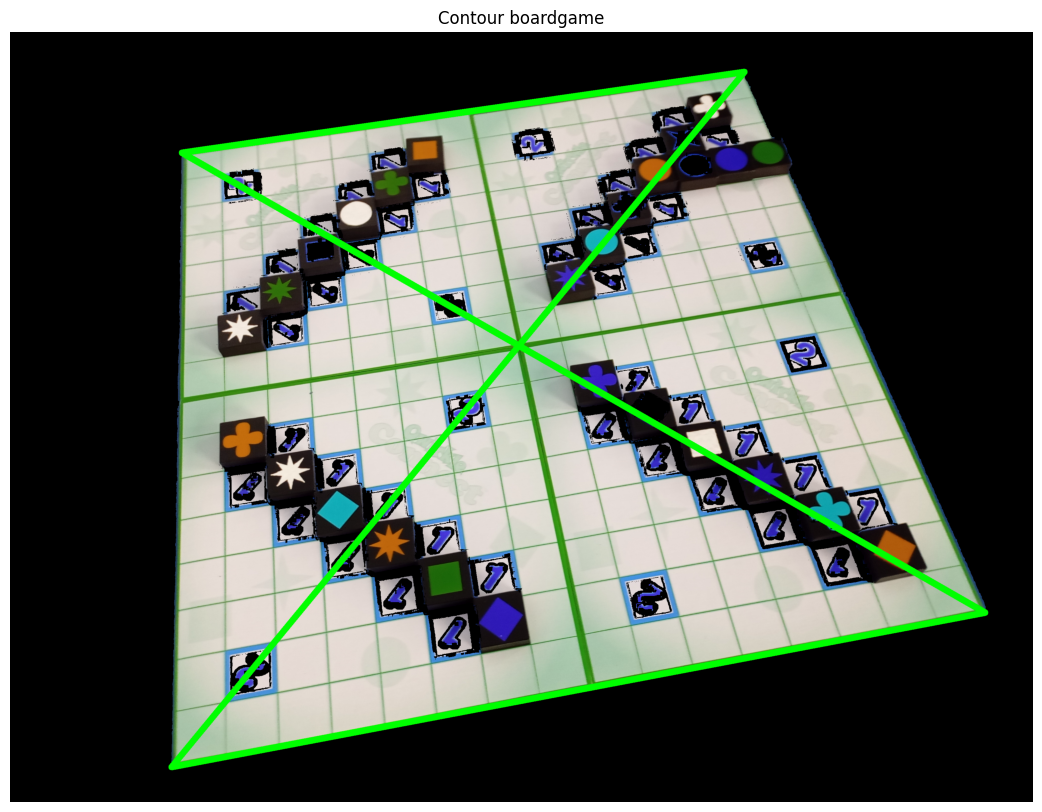

In [9]:
# """
# Wrapping image T influences image T+1 as this experiment shows it.
# """
# 
# image = warp_image_to_starting_image_SIFT("2_01", warp)
# image = warp_image_to_starting_image_SIFT("2_02", image)
# image = warp_image_to_starting_image_SIFT("2_03", image)
# image = warp_image_to_starting_image_SIFT("2_04", image)
# image = warp_image_to_starting_image_SIFT("2_05", image)
# image = warp_image_to_starting_image_SIFT("2_06", image)
# image = warp_image_to_starting_image_SIFT("2_07", image)
# image = warp_image_to_starting_image_SIFT("2_08", image)
# image = warp_image_to_starting_image_SIFT("2_09", image)

## Fourth Chapter of the Adventure
**How to extract pieces from the table?**

Maybe template matching or SIFT descriptors where matches land near a position consider the maximum matches points to represent the position for that

In [62]:
import re
from collections import defaultdict

templates_config = {
    'red': glob.glob(os.path.join('./datasets/templates', 'red_*.png')),
    'orange': glob.glob(os.path.join('./datasets/templates', 'orange_*.png')),
    'blue': glob.glob(os.path.join('./datasets/templates', 'blue_*.png')),
    'yellow': glob.glob(os.path.join('./datasets/templates', 'yellow_*.png')),
    'green': glob.glob(os.path.join('./datasets/templates', 'green*.png')),
    'white': glob.glob(os.path.join('./datasets/templates', 'white_*.png')),
}

def shape_name_to_code(color_name, pattern_name):
    code = ""
    match_shape_name = re.search(r'.*\_(.*)\.png', pattern_name)
    if match_shape_name is None:
        raise Exception("Cannot find shape name in the name of the template.")
    
    shape_name = match_shape_name.group(1)
    if shape_name == "circle":
        code += "1"
    elif shape_name == "clover":
        code += "2"
    elif shape_name == "diamond":
        code += "3"
    elif shape_name == "square":
        code += "4"
    elif shape_name == "star":
        code += "5"
    elif shape_name == "8-star":
        code += "6"
    else:
        code += "?"
        
    if color_name == "red":
        code += "R"
    elif color_name == "orange":
        code += "O"
    elif color_name == "blue":
        code += "B"
    elif color_name == "yellow":
        code += "Y"
    elif color_name == "green":
        code += "G"
    elif color_name == "white":
        code += "W"
    else:
        code += "?"
    return code
    

image_copy = warp_with_gap.copy()
game_matrix = [["?"] * 16 for _ in range(16)]
for i, patch_i in enumerate(range(16, 976, 60)):
    for j, patch_j in enumerate(range(16, 976, 60)):
        pattern = image_copy[patch_i-16:patch_i+60+16, patch_j-16:patch_j+60+16]
        
        color_detections = defaultdict(list)
        for color_name, template_paths in templates_config.items():
            for template_path in template_paths:
                current_template = cv.imread(template_path, cv.IMREAD_COLOR_BGR|cv.IMREAD_IGNORE_ORIENTATION)
                h, w = current_template.shape[:2]
                
                res = cv.matchTemplate(pattern, current_template, cv.TM_CCOEFF_NORMED)
                maximum_result_coefficient = np.max(res)
                
                color_detections[color_name].append((maximum_result_coefficient, template_path))
            color_detections[color_name] = max(color_detections[color_name], key=lambda element: element[0])
        
        color_key = max(color_detections, key=lambda element: color_detections[element][0])
        if color_detections[color_key][0] > 0.8:
            code = shape_name_to_code(color_key, color_detections[color_key][1])
            game_matrix[i][j] = code

print(*game_matrix, sep="\n")

['?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?']
['?', '2G', '6G', '5G', '3G', '4G', '1G', '?', '?', '?', '?', '?', '?', '?', '4G', '?']
['?', '?', '?', '?', '?', '4O', '1O', '?', '?', '?', '?', '?', '2R', '6R', '?', '?']
['?', '?', '?', '?', '3R', '?', '1W', '?', '?', '?', '1G', '?', '2W', '?', '?', '?']
['?', '2Y', '6Y', '1Y', '3Y', '?', '1B', '?', '?', '?', '6G', '6O', '?', '?', '?', '?']
['?', '?', '6B', '?', '3B', '?', '?', '?', '?', '?', '5G', '?', '?', '?', '?', '?']
['?', '6W', '?', '?', '3W', '?', '?', '?', '?', '3R', '?', '?', '?', '?', '?', '?']
['?', '?', '?', '?', '3G', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?']
['?', '?', '?', '?', '3O', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?']
['3W', '3R', '3Y', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '2Y', '?']
['?', '?', '1Y', '4Y', '5Y', '2Y', '6Y', '?', '?', '?', '?', '?', '?', '6B', '?', '?']
['?', '?', '?', '4W', '?', '?', '?', '?', '?', '?', '?', '?', '3G', '

55 55
(92, 92, 3)
[0.03279221 0.05257447 0.07411294 0.09598704 0.11796872 0.1399509
 0.16209328 0.18500759 0.20937718 0.23688242 0.26782274 0.30224225
 0.33840433 0.3769712  0.41724414 0.46025267 0.5027135  0.543255
 0.58045053 0.6130646  0.6398701  0.66184855 0.6798336  0.6938289
 0.7036545  0.7093883  0.71130615 0.7097802  0.7047844  0.6958906
 0.68290234 0.66587687 0.6445101  0.6187356  0.58857906 0.55445856
 0.51693946 0.4767218 ]
(938, 938)
(array([558, 558, 558, 559, 559, 559, 560, 560, 560, 739, 739, 740, 740,
       740, 740, 741, 741, 741, 741, 742, 742]), array([138, 139, 140, 138, 139, 140, 138, 139, 140, 256, 257, 255, 256,
       257, 258, 255, 256, 257, 258, 256, 257])) [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(array([558, 558, 558, 559, 559, 559, 560, 

Text(0.5, 1.0, 'Lets seee')

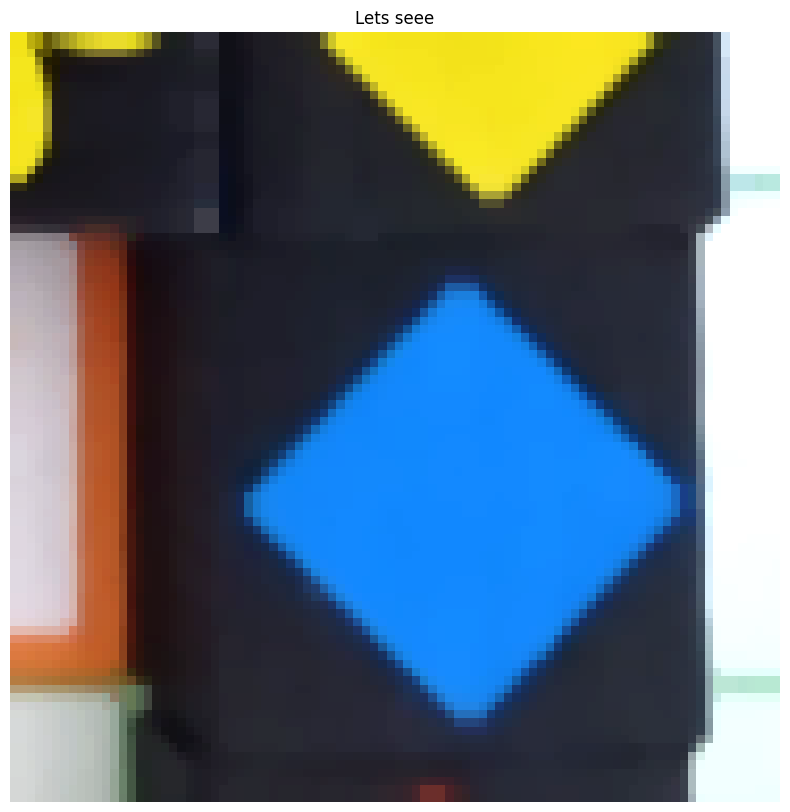

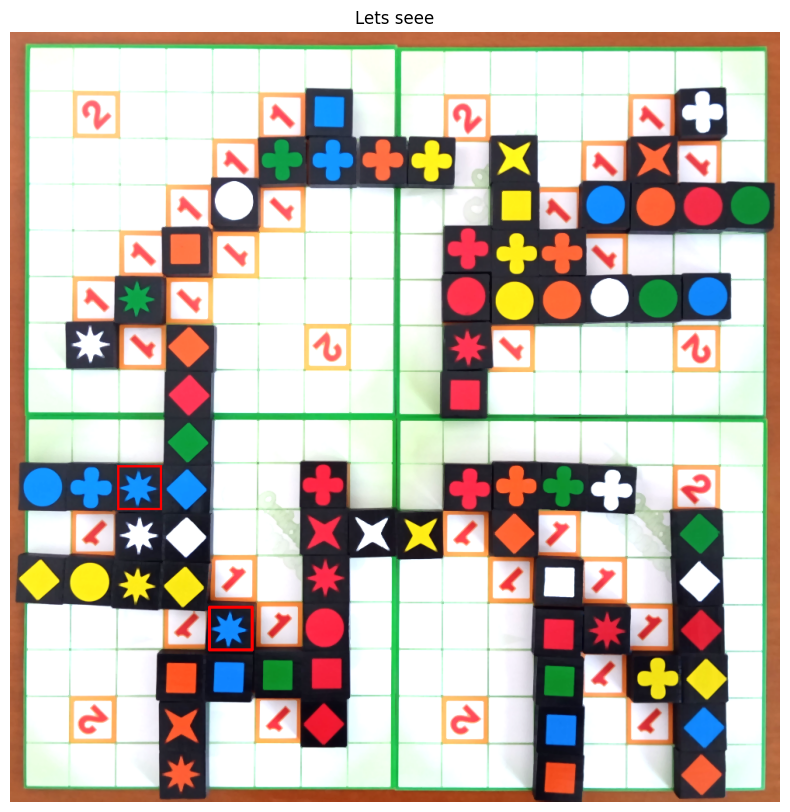

In [101]:
template = cv.imread("./datasets/templates/blue_8-star.png", cv.IMREAD_COLOR_BGR|cv.IMREAD_IGNORE_ORIENTATION)
# only resize if needed TODO
h, w = template.shape[:2]
print(h, w)
image_copy = warp_with_gap.copy()
other_image_copy = warp_with_gap.copy()
# pattern1 = image_copy[720-10:780+10, 840-10:900+10]
pattern1 = image_copy[856-16:916+16, 856-16:916+16]
# pattern1 = image_copy[0:60+10, 300-10:360+10]
# pattern1 = image_copy[600-5:660-5, 120+5:180+5]

pattern1 = cv.morphologyEx(pattern1, cv.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=1)
print(pattern1.shape)
image_copy = cv.morphologyEx(image_copy, cv.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)
res = cv.matchTemplate(other_image_copy, template, cv.TM_CCOEFF_NORMED)
res1 = cv.matchTemplate(pattern1, template, cv.TM_CCOEFF_NORMED)
print(np.max(res1, axis=1))
threshold = 0.85
loc1 = np.where( res1 >= threshold)
for pt in zip(*loc1[::-1]):
    cv.rectangle(pattern1, pt, (pt[0] + h, pt[1] + w), (0,0,255), 1)
plt.figure(figsize=[40, 10])
plt.axis('off'); plt.imshow(cv.cvtColor(pattern1, cv.COLOR_BGR2RGB)); plt.title('Lets seee')
print(res.shape)
threshold = 0.9
loc = np.where( res >= threshold)
print(loc, res >= threshold)
print(loc)
for pt in zip(*loc[::-1]):
    cv.rectangle(other_image_copy, pt, (pt[0] + h, pt[1] + w), (0,0,255), 1)
# 0 60 120 180 240 300 360 420 480 540 600 660 720 780 840 900 960
plt.figure(figsize=[40, 10])
plt.axis('off'); plt.imshow(cv.cvtColor(other_image_copy, cv.COLOR_BGR2RGB)); plt.title('Lets seee')

Text(0.5, 1.0, 'Lets seee')

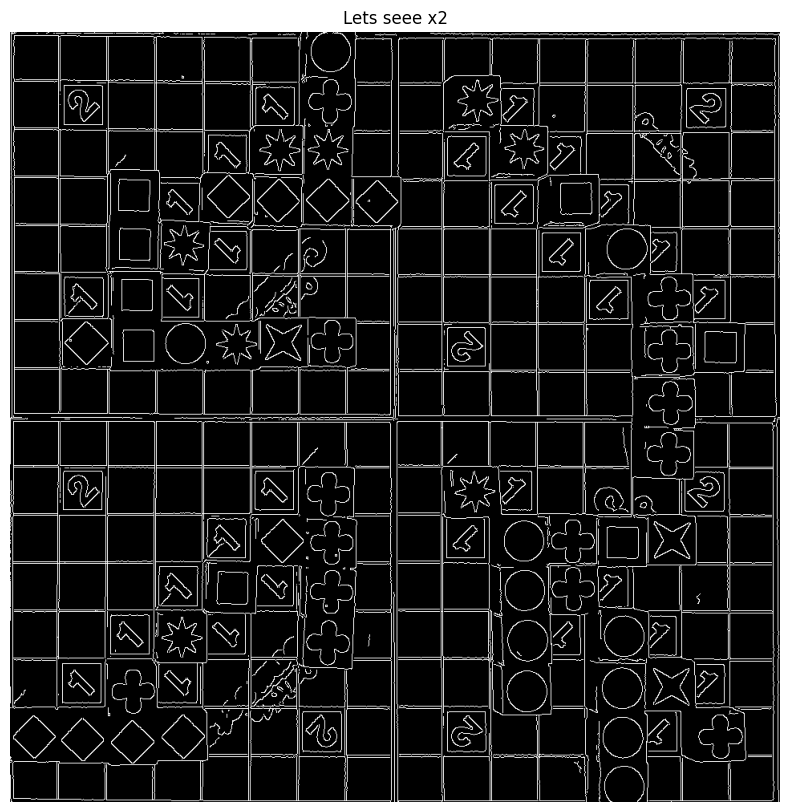

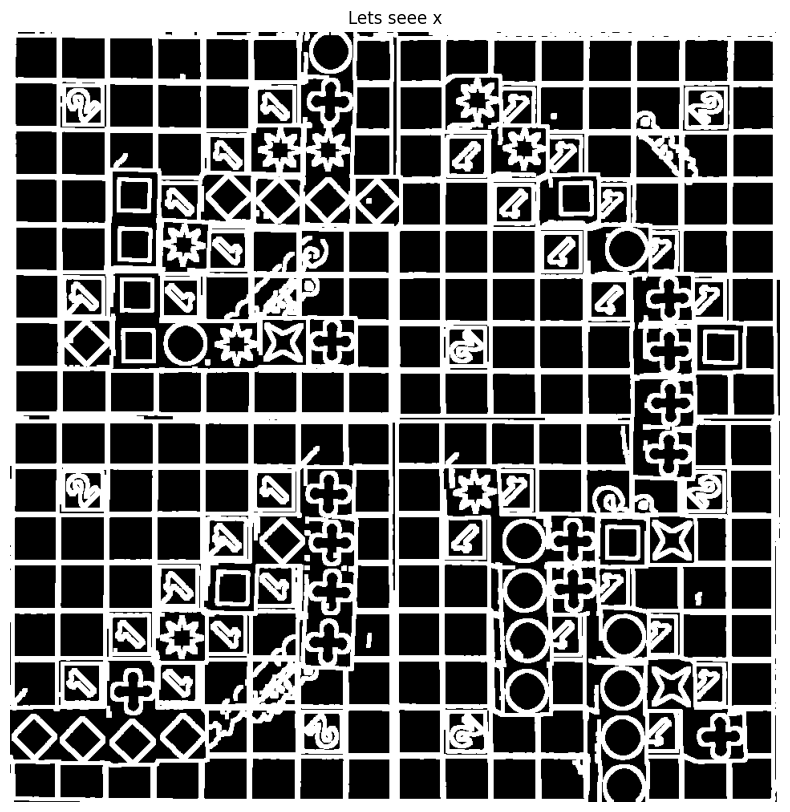

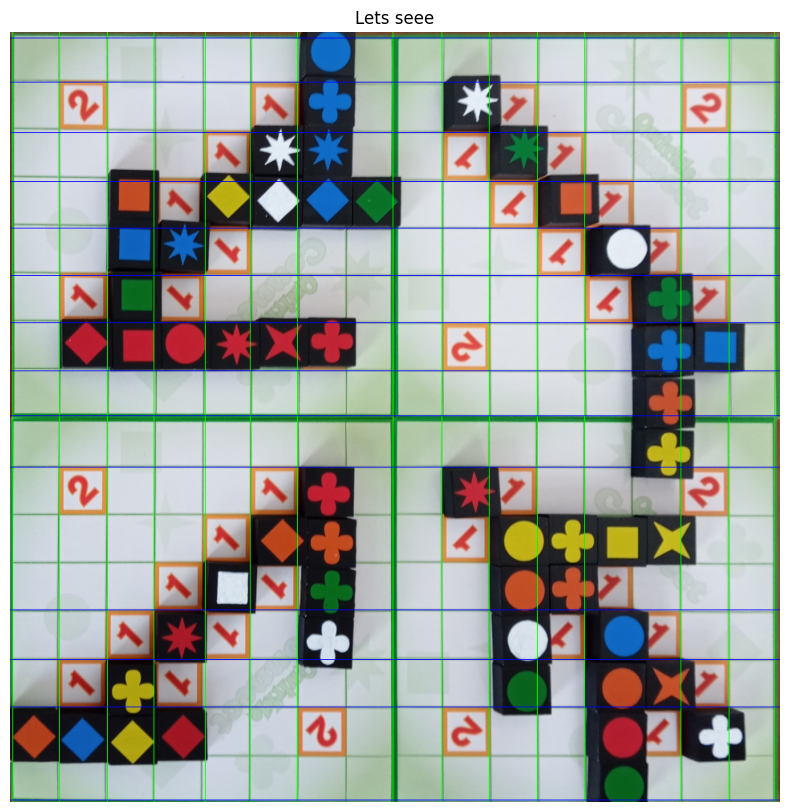

In [12]:
def generate_horizontal_vertical_lines(img):
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray_img, 40, 70, apertureSize=3)
    plt.figure(figsize=[40, 10])
    plt.axis('off'); plt.imshow(cv.cvtColor(edges, cv.COLOR_BGR2RGB)); plt.title('Lets seee x2')
    
    kernel_edges = np.ones((3, 3), np.uint8)
    dilated_edges = cv.dilate(edges, kernel_edges, iterations=2)
    plt.figure(figsize=[40, 10])
    plt.axis('off'); plt.imshow(cv.cvtColor(dilated_edges, cv.COLOR_BGR2RGB)); plt.title('Lets seee x')
    lines = cv.HoughLinesP(dilated_edges,
                            rho=1,
                            theta=np.pi/180,
                            threshold=200,
                            minLineLength=warp.shape[1]//2,
                            maxLineGap=20)
    
    horiz, vert = [], []
    for x1,y1,x2,y2 in lines[:,0]:
        if abs(y2-y1) < 10:
            horiz.append((x1,y1,x2,y2))
        elif abs(x2-x1) < 10:
            vert.append((x1,y1,x2,y2))
    return horiz, vert

def cluster_line_positions(lines, orientation='vertical', tol=20):
    coords = []
    for x1, y1, x2, y2 in lines:
        coords.append(((x1+x2)//2) if orientation=='vertical' else ((y1+y2)//2))
    coords.sort()
    clusters = []
    for c in coords:
        if not clusters or abs(c - clusters[-1][0]) > tol:
            clusters.append([c])
        else:
            clusters[-1].append(c)
    centers = [int(np.mean(cluster)) for cluster in clusters]
    return sorted(centers)

horiz, vert = generate_horizontal_vertical_lines(warp)
xs = cluster_line_positions(vert, 'vertical', tol=20)
ys = cluster_line_positions(horiz, 'horizontal', tol=20)

"""
DEBUG CHECK LINES:
"""
def draw_grid_lines(board, xs, ys):
    img = board.copy()
    for x in xs:
        cv.line(img, (x, 0), (x, img.shape[0]), (0, 255, 0), 1)
    for y in ys:
        cv.line(img, (0, y), (img.shape[1], y), (255, 0, 0), 1)
    return img

img = draw_grid_lines(warp, xs, ys)
plt.figure(figsize=[40, 10])
plt.axis('off'); plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)); plt.title('Lets seee')

